In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=23)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Gaussian mixture

## Background

Gaussian mixture is a supervized machine learning algorithm which aims at representing the data as if points were drawn from multidimensional gaussian distributions. It does it by combining maximum likelihood and Bayes rules in what is refered as the Expectation Maximisation algorithm.

Quickly:

you want to represent the data as the following density probability function:

$P(\textbf{X}=\overrightarrow{x_{i}};\pmb{\tau},\pmb{\theta})=\sum_{g=1}^{G}\tau_{g}f_{g}(\overrightarrow{x_{i}};\pmb{\theta_{g}})$ (1)

Where the data are supposedly seprarable into G groups, $\tau$ is the distribution of the mixture ($P(\textbf{G}=g_{i})$) and $f_g$ is a multidimensional gaussian density function of parameters $\pmb{\theta_{g}}$. Explicitly,

$f_{g}(\overrightarrow{x_{i}};\pmb{\theta_{g}})=\frac{exp((\overrightarrow{x_{i}}-\overrightarrow{\mu_{g}})^{T}\pmb{\Sigma^{-1}}(\overrightarrow{x_{i}}-\overrightarrow{\mu_{g}}))}{\sqrt{2\pi\det\pmb{\Sigma}}}$(2)

Where of course $\mu$ and $\Sigma$ are respectively the vector of means and the covariance matrix.

A straightforward, and usual, maximum likelihood estimation taking into account our knowledge of the groups would look like the following:

$L(\pmb{\theta},\pmb{x},\pmb{z})=\Pi_{g=1}^{G}\Pi_{i=1}^{N}z_{i,g}f_{g}(\overrightarrow{x_{i}};\pmb{\theta_{g}})$(3)

where $z_{i,g}=1$ if point i is indeed in group g, and 0 otherwise.

However we don't have access to that knowledge on new data points. So what we can do instead is estimate the probability that a point is part of a group using Bayes theorem (expectation part of the algorithm). From that estimation we maximize the likelihood of our mixture of gaussians (maximization step). We loop over those two steps feeding the expectation part with maximized estimates from the maximization step until some threshold.
In practice for Gaussian function f for which we have an analytic solution of the maximization part, the algo looks like the following:

Expectation

$T_{i,g}^{(t)}=P(Z_{i}=g|\textbf{X}=\overrightarrow{x_{i}};\pmb{\theta^{(t)}})=\frac{\tau_{g}^{(t)}f_{g}(\overrightarrow{x_{i}};\pmb{\theta_{g}^{(t)}})}{\sum_{g=1}^{G}\tau_{g}^{(t)}f_{g}(\overrightarrow{x_{i}};\pmb{\theta_{g}^{(t)}})}$(4)

It can be shown that the solution that maximizes (3) can be approached by maximizing the following probability function :

$Q(\pmb{\theta}|\pmb{\theta^{(t)}})=\textbf{E}_{\textbf{Z}|\textbf{X},\pmb{\theta^{(t)}}}(log(L(\pmb{\theta},\pmb{x},\pmb{z})))=\sum_{i=1}^{N}\sum_{g=1}^{G}T_{i,g}^{(t)}log(\tau_{g}f_{g}(\overrightarrow{x_{i}};\pmb{\theta_{g}}))$(5)

Hence the "expectation" name of this step

Maximization

Using our kowledge from the expectation part and since f is gaussian we have direct analytical solution for the maximum likelihood estimator of probability density function (5) that we will use to update our expectation step and stop the algo whenever this maximization is good enough according to a certain threshold.

Analytical solution for maximumlikelihood of (5) are

$\tau_{g}^{(t+1)}=\frac{1}{N}\sum_{i=1}^{N}T_{i,g}^{(t)}$

$\overrightarrow{\mu_{g}^{(t+1)}}=\frac{\sum_{i=1}^{N}T_{i,g}^{(t)}\overrightarrow{x_{i}}}{\sum_{i=1}^{N}T_{i,g}^{(t)}}$

$\pmb{\Sigma_{g}^{(t+1)}}=\frac{\sum_{i=1}^{N}T_{i,g}^{(t)}(\overrightarrow{x_{i}}-\overrightarrow{\mu_{g}^{(t+1)}})^{T}(\overrightarrow{x_{i}}-\overrightarrow{\mu_{g}^{(t+1)}})}{\sum_{i=1}^{N}T_{i,g}^{(t)}}$

## How can it be parallelized?

- There is quite a bit of matrix multiplication

- It is a loglikelihood function so each terms can be calculated independantly and only then summed

As it is coded below the algo is incredibly slow compared to what scikit offers. I tried to work with cuda and numba but can't really figure out some important stupid little things like why some types that should be accepted by jit or cuda are not...

In anycase this is the code that you could expect from someone having knowledge in python but not formaly trained as a computer scientist.

In [2]:
import numba

def log_likelihood(features,data2,components,max_iter,dtol):
    ### this part is just about getting the features that are stored as a list, in the right format.
    dim=data2.shape[1]
    p1=components*dim
    p2=int(((dim*(dim-1))/2+dim))
    n_point=len(data2)
   
    mu=features[:p1].reshape((components,dim))
    f=features[p1:p1+p2*components]
    
    sigma=[]
    ### particularly here is to ensure that we do end up with a symetrical positive matrix for the correlation matrix
    for k in range(components):
        fif=f[k*p2:(k+1)*p2]
        arr = np.zeros((dim,dim))
        arr[np.tril_indices(dim,)] = fif
        arr += arr.T
        arr-=0.5*arr*np.eye(dim)
        sigma.append(arr)
            
    frac=features[p1+p2*components:]
    remaining_proba=1-np.sum(frac)### ensuring that proba to be on one class or the other sum to one.
    
    frac=np.array(list(frac)+[remaining_proba])
    

    st=(2*np.pi)**(-dim/2)
    

    diff=1000
    pp=0
    
    while pp<max_iter and diff>dtol:
        ###### Expectation
        
        ### I don't think expending those loops (that rae loops other the classes) is worth the effort, so I will not change it
        ### in the jit code.
        sigma_inv=[np.linalg.inv(sigma[i]) for i in range(len(sigma))]

        ### Same here the loop is only other the classes
        cst=[st*(np.linalg.det(sigma[j]))**(-0.5) for j in range(components)]
                
        ### This will be later on replace by the expended loop : tik (see JIT and else)  
        t_i_k=[np.array([frac[k]*cst[k]*np.exp(-0.5*((data2[i]-mu[k]).T@sigma_inv[k]@(data2[i]-mu[k])))
                                   for i in range(n_point)])for k in range(components)]

        
        t_i_k=np.array(t_i_k)
        tot=np.sum(t_i_k,axis=0)
        
        t_i_k/=tot
        if pp==0:
            ### This will be replaced later on by the expended loop : vectorized_answer_array (see JIT and else). Indeed jit 
            ### doesn't handle nested comprehension list
            answer=np.sum([np.sum([(t_i_k[j,i])*(np.log(frac[j]*cst[j])-0.5*((data2[i]-mu[j]).T@sigma_inv[j]@(data2[i]-mu[j])))
                                   for j in range(components) ]) for i in range(n_point)])

        v_k=np.sum(t_i_k,axis=1)
        
        ###### Maximization
        new_frac=v_k/n_point
        ### This will be replaced later on by the expended loop : newmu (see JIT and else).
        new_mu=np.array([np.array([(t_i_k[k,:]@data2[:,i])/v_k[k] for i in range(dim)])for k in range(components)])
        

        ### This will be replaced later on by the expended loop : newsigma (see JIT and else).
        new_sigma=[(data2-new_mu[k]).T@((data2-new_mu[k])*(t_i_k[k,:].reshape((data2.shape[0],1))))/v_k[k] for k in range(components)]


        new_cst=[st*(np.linalg.det(new_sigma[j]))**(-0.5) for j in range(components)]

        new_sigma_inv=[np.linalg.inv(new_sigma[i]) for i in range(len(new_sigma))]

        ### This will be replaced later on by the expended loop : vectorized_answer_array (see JIT and else).
        new_answer=np.sum([np.sum([(t_i_k[j,i])*(np.log(new_frac[j]*new_cst[j])-0.5*((data2[i]-new_mu[j]).T@new_sigma_inv[j]@(data2[i]-new_mu[j])))
                                for j in range(components) ]) for i in range(n_point)])                       
        
        ###### Looping
        diff=abs(new_answer-answer)
        if new_answer-answer>=dtol :
            frac=new_frac
            sigma=new_sigma
            mu=new_mu
            answer=new_answer
        else:
            break
        pp+=1

    ##### Getting the estimated parameters out    
    sigma_res=[]
    for k in range(len(sigma)):
        vv=np.tril(sigma[k]).T.ravel()
        vv=vv[vv!=0]
        sigma_res+=list(vv)
    
    ret=np.concatenate((mu.ravel(),np.array(sigma_res),frac[:-1]))
    #print(pp,diff)
    
    return ret



#### Estimating the parameters in a straightforward way for the inital guess : basically calculating vector of means
#### covariance matrice and overall group distribution, by being group specific. 
def initial_guess(data,dico_class,components):
    list_i=[[s for s  in dico_class.keys() if dico_class[s]==k] for k in range(components)]
    dico_mean={}
    dico_cov={}
    dico_frac={}
    for k in range(components):
        x=np.array([data[i,:] for i in list_i[k]])
        dico_mean[k]=np.mean(x,axis=0)
        
        dico_cov[k]=np.cov(x.T)
        dico_frac[k]=len(x)/data.shape[0]
    return_list=[]
    for k in range(components):
        return_list+=list(dico_mean[k])
    for k in range(components):
        vv=np.tril(dico_cov[k]).T.ravel()
        vv=vv[vv!=0]
        return_list+=list(vv)
    for k in range(components-1):
        return_list+=[dico_frac[k]]
    
    return np.array(return_list)




from operator import itemgetter

def function_eval(features,data,components):
    dim=data.shape[1]
    p1=components*dim
    p2=int(((dim*(dim-1))/2+dim))
    n_point=len(data)
    data2=np.array([data[i,:] for i in range(n_point)])
    mu=features[:p1].reshape((components,dim))
    f=features[p1:p1+p2*components]
    
    sigma=[]
    for k in range(components):
        fif=f[k*p2:(k+1)*p2]
        arr = np.zeros((dim,dim))
        indices = np.tril_indices(dim,)
        arr[indices] = fif
        arr += arr.T
        arr-=0.5*arr*np.eye(dim)
        sigma.append(arr)
        
    frac=features[p1+p2*components:]
    frac=np.array(list(frac)+[1-sum(frac)])
    #print(frac)
    
    sigma_inv=[np.linalg.inv(sigma[i]) for i in range(len(sigma))]


    cst=[((2*np.pi)**(dim)*np.linalg.det(sigma[j]))**(-0.5) for j in range(components)]
    
    t_i_k=[[frac[k]*cst[k]*np.exp(-0.5*((data2[i]-mu[k]).T@sigma_inv[k]@(data2[i]-mu[k])))
                               for i in range(n_point)]for k in range(components)]
    
    t_i_k=np.array(t_i_k)
    #print(type(t_i_k[0,0]))
    tot=np.sum(t_i_k,axis=0)
    t_i_k/=tot
    dico_t_i_k={i:sorted([[k,t_i_k[k,i]] for k in range(components)],key=itemgetter(1),reverse=True) for i in range(n_point)}
    decision={i:dico_t_i_k[i][0][0] for i in range(n_point)}###get highest gaussian compoant for each point
    return decision,dico_t_i_k

### Generating data

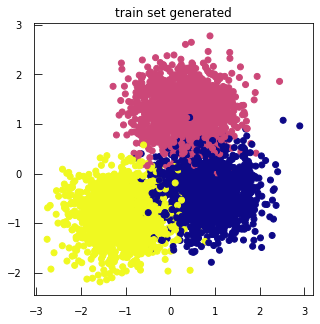

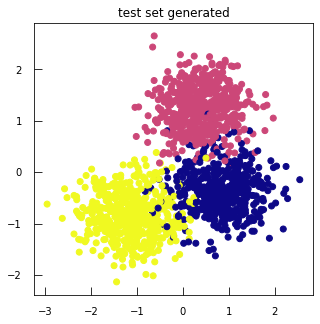

In [40]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#Generating data

X, y = make_blobs(n_samples=6000, centers=3,cluster_std=3, random_state=100)#2000 points per class in 2D

## Usual train test splitting for machine learning

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=0)
dico_class_train={i:y_train[i] for i in range(len(X_train))}
dico_class_test={i:y_test[i] for i in range(len(X_test))}

## always scale your data whenever you are uding a distance based metric like here.

from sklearn.preprocessing import StandardScaler 
scaler=StandardScaler()
scaler.fit(X_train)
big_X=scaler.transform(X_train)

big_X1=scaler.transform(X_test)

plt.figure(figsize=(5,5))
plt.scatter(big_X[:,0],big_X[:,1],c=y_train,cmap='plasma')
plt.title('train set generated')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(big_X1[:,0],big_X1[:,1],c=y_test,cmap='plasma')
plt.title('test set generated')
plt.show()

### Testing algo

In [299]:
x0=initial_guess(big_X,dico_class_train,3)



R=log_likelihood(x0,big_X,3,100,10**-3)




R0,R1=function_eval(R,big_X1,3)



In [296]:
%timeit log_likelihood(x0,big_X,3,100,10**-3)

7.93 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


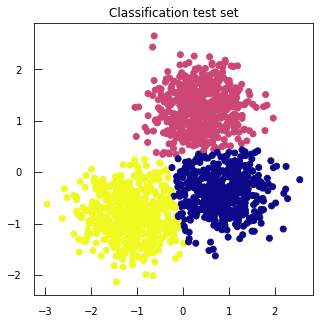

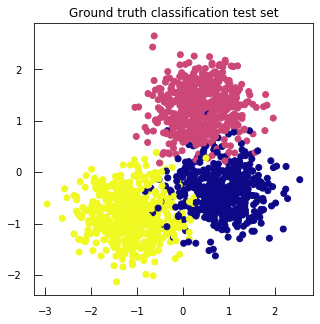

In [5]:
plt.figure(figsize=(5,5))
plt.scatter(big_X1[:,0],big_X1[:,1],c=[R0[i] for i in range(len(big_X1))],cmap='plasma')
plt.title('Classification test set')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(big_X1[:,0],big_X1[:,1],c=[dico_class_test[i] for i in range(len(big_X1))],cmap='plasma')
plt.title('Ground truth classification test set')
plt.show()

### Evaluation on training

In [6]:
R02,R12=function_eval(R,big_X,3)

[0.32882179 0.33419467 0.33698354]


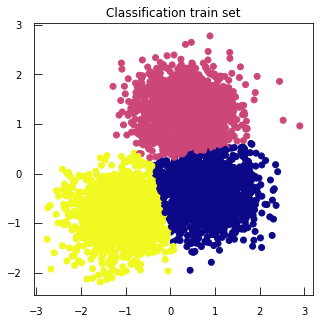

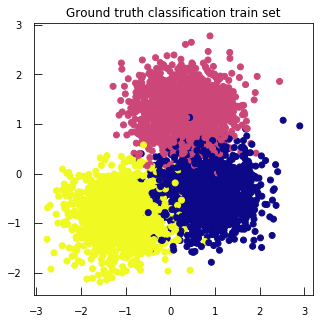

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(big_X[:,0],big_X[:,1],c=[R02[i] for i in range(len(big_X))],cmap='plasma')
plt.title('Classification train set')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(big_X[:,0],big_X[:,1],c=[dico_class_train[i] for i in range(len(big_X))],cmap='plasma')
plt.title('Ground truth classification train set')
plt.show()

### JIT and else

Let's recode that algo in a less pythonic way so that jit can use it. We will do it only for log likelihood function and not for the eval and initial guess.

We use njit as a decorator as it allows you to be in nopython mode as default. This is important because if you are not in no python mode and a jit doesn't understand one of your code line it will switch back to python without mentioning the error and you will see no improvment in your code.

Most of the time to use jit, you just have to expend your for loops, making sure all the feature you are using are supported by numba and most important of all that your types are well defined. You can use the key parallel tu paralele on all the cpus available. I am not sure nogil is really important when using parallel=True since parallel should release the gil (Global Interpreter Lock) anyway... If you want to parallelize on gpu replace the parallel=True by target='gpu'.

I am not 100% sure but i think by adding a signature to your jit (i.e. describing size and type of your input variables and output variable) you can make it even faster.

In [3]:
import numba
from numba import njit
from numba import guvectorize,vectorize,float64,int32,float32
from numba import prange

@njit(nogil=True,parallel=True)                                         
def vectorized_answer_array(t_i_k,new_frac,new_cst,data2,new_mu,new_sigma_inv):#,answ):
    answ=np.empty(np.shape(t_i_k))
    for j in prange(answ.shape[0]):
        for i in prange(answ.shape[1]):
            a=data2[i]-new_mu[j]
            answ[j,i]=t_i_k[j,i]*(np.log(new_frac[j,0]*new_cst[j,0])-0.5*np.dot(np.dot(np.transpose(a),new_sigma_inv[j]),(a)))
    return answ

                  


@njit(nogil=True,parallel=True)
def tik(frac,cst,data2,mu,sigma_inv,components,n_point):
    t_i_k=np.empty((components,n_point))#,dtype=float64)
    for k in prange(components):
        
        for i in prange(n_point):
            a=data2[i]-mu[k]
            t_i_k[k,i]=frac[k,0]*cst[k,0]*np.exp(-0.5*np.dot(np.dot(np.transpose(a),sigma_inv[k]),(a)))
    return t_i_k

@njit(nogil=True,parallel=True)   
def newmu(t_i_k,data2,v_k,components,n_point):
    new_mu=np.empty((components,data2.shape[1]))#,dtype=float64)
    for k in prange(components):
        for i in prange(data2.shape[1]):
            new_mu[k,i]=np.dot(t_i_k[k,:],data2[:,i])/v_k[k,0]
    return new_mu

@njit(nogil=True,parallel=True)
def newsigma(data2,new_mu,t_i_k,v_k):
    new_sigma=np.empty((new_mu.shape[0],data2.shape[1],data2.shape[1]))
    for k in prange(new_mu.shape[0]):
        a=data2-new_mu[k]
        new_sigma[k]=np.dot(np.transpose(a),np.multiply((a),t_i_k[k,:].reshape(data2.shape[0],1)))/v_k[k,0]
        
    return new_sigma



In [414]:
def log_likelihood_jit(features,data2,components,max_iter,dtol):
    dim=data2.shape[1]
    p1=components*dim
    p2=int(((dim*(dim-1))/2+dim))
    n_point=len(data2)
   
    mu=features[:p1].reshape((components,dim))
    f=features[p1:p1+p2*components]
    
    sigma=[]
    for k in range(components):
        fif=f[k*p2:(k+1)*p2]
        arr = np.zeros((dim,dim))
        arr[np.tril_indices(dim,)] = fif
        arr += arr.T
        arr-=0.5*arr*np.eye(dim)
        sigma.append(arr)
        
        
    frac=features[p1+p2*components:]
    peanuts=1-np.sum(frac)
    
    frac=np.array(list(frac)+[peanuts]).reshape((components,1))
    

    st=(2*np.pi)**(-dim/2)
    

    diff=1000
    pp=0
    
    while pp<max_iter and diff>dtol:
        
        sigma_inv=np.array([np.linalg.inv(sigma[i]) for i in range(components)],dtype=np.float64).reshape((components,dim,dim))

        
        cst=np.array([st*(np.linalg.det(sigma[j]))**(-0.5) for j in range(components)],dtype=np.float64).reshape((components,1))
        
        ### As explain before the nested comprehension list have been repaced by jit expended loops        
        t_i_k=tik(frac,cst,data2,mu,sigma_inv,components,n_point)

        
        
        tot=np.sum(t_i_k,axis=0)
        
        t_i_k/=tot
        if pp==0:
            ### As explain before the nested comprehension list have been repaced by jit expended loops 
            answer=np.sum(vectorized_answer_array(t_i_k,frac,cst,data2,mu,sigma_inv))

        v_k=np.sum(t_i_k,axis=1).reshape((components,1)).reshape((components,1))
        new_frac=v_k/n_point
        ### As explain before the nested comprehension list have been repaced by jit expended loops 
        new_mu=newmu(t_i_k,data2,v_k,components,n_point)
        

        ### As explain before the nested comprehension list have been repaced by jit expended loops 
        new_sigma=newsigma(data2,new_mu,t_i_k,v_k)

        new_cst=np.array([st*(np.linalg.det(new_sigma[j]))**(-0.5) for j in range(components)],dtype=np.float64).reshape((components,1))

        new_sigma_inv=np.array([np.linalg.inv(new_sigma[i]) for i in range(components)],dtype=np.float64).reshape((components,dim,dim))

        ### As explain before the nested comprehension list have been repaced by jit expended loops 
        new_answer=np.sum(vectorized_answer_array(t_i_k,new_frac,new_cst,data2,new_mu,new_sigma_inv))                       
        diff=abs(new_answer-answer)
        if new_answer-answer>=dtol :
            frac=new_frac
            sigma=new_sigma
            mu=new_mu
            answer=new_answer
        else:
            break
        pp+=1

        
    mich=[]
    for k in range(len(sigma)):
        vv=np.tril(sigma[k]).T.ravel()
        vv=vv[vv!=0]
        mich+=list(vv)
    
    ret=np.concatenate((mu.ravel(),np.array(mich),frac[:-1].ravel()))
    
    return ret







In [353]:
x0=initial_guess(big_X,dico_class_train,3)



R=log_likelihood_jit(x0,big_X,3,100,10**-3)




R0,R1=function_eval(R,big_X1,3)

<ipython-input-351-9d6f0f2c06ac>:32: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  new_mu[k,i]=np.dot(t_i_k[k,:],data2[:,i])/v_k[k,0]


[0.32882179 0.33419467 0.33698354]


In [407]:
%timeit log_likelihood_jit(x0,big_X,3,100,10**-3)

<ipython-input-405-d1b991f7d48d>:33: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  new_mu[k,i]=np.dot(t_i_k[k,:],data2[:,i])/v_k[k,0]


288 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [421]:
#no parallel
%timeit log_likelihood_jit(x0,big_X,3,100,10**-3)

<ipython-input-420-bc02fda31f95>:33: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  new_mu[k,i]=np.dot(t_i_k[k,:],data2[:,i])/v_k[k,0]


371 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [425]:
#no jit
%timeit log_likelihood_jit(x0,big_X,3,100,10**-3)

5.62 s ± 170 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


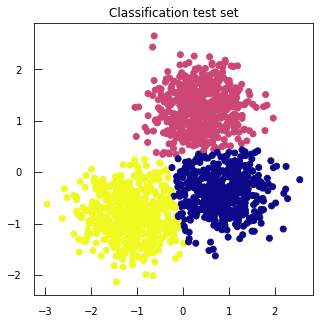

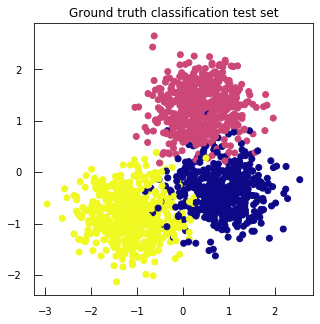

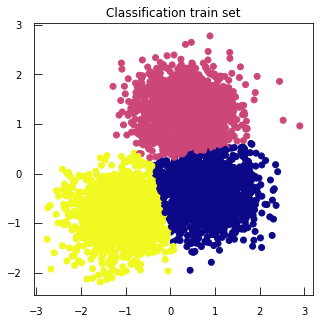

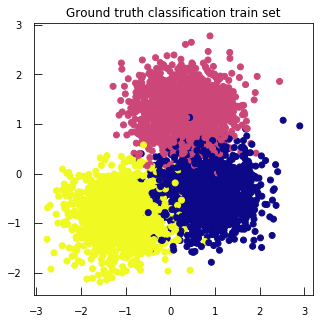

In [298]:
plt.figure(figsize=(5,5))
plt.scatter(big_X1[:,0],big_X1[:,1],c=[R0[i] for i in range(len(big_X1))],cmap='plasma')
plt.title('Classification test set')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(big_X1[:,0],big_X1[:,1],c=[dico_class_test[i] for i in range(len(big_X1))],cmap='plasma')
plt.title('Ground truth classification test set')
plt.show()

R02,R12=function_eval(R,big_X,3)


plt.figure(figsize=(5,5))
plt.scatter(big_X[:,0],big_X[:,1],c=[R02[i] for i in range(len(big_X))],cmap='plasma')
plt.title('Classification train set')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(big_X[:,0],big_X[:,1],c=[dico_class_train[i] for i in range(len(big_X))],cmap='plasma')
plt.title('Ground truth classification train set')
plt.show()


### Still a long way to go if we compare to scikitlearn implementation.

In [300]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,max_iter=100,tol=10**-3)
%timeit GM.fit(X_train,y_train)

9.52 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Damped oscillator (Youtube channel Jack of Some or github : https://github.com/safijari/jack-of-some/projects/1)

## Background

Most material taken from Jack of Some

We would like to study a dynamical system known as a damped oscillator. It is basically nothing more than a mass attached to a spring, moving in some fluid that excerces a friction force on it and under a gravitational accelaration. In this simple example the mass can only move in the vertical direction along the x axis. We are going to consider non linear friction force so that the whole dynamic becomes dependant on the starting point (where did you drop the mass), and analytical solutions are unknown. We would like to understand how the initial condition influences the dynamic of this pendulum.

Mathematically speaking we are looking at a system described by the following non linear second order ordinary differential equation.

$m\ddot x=c(\dot x)-kx$

Where m is the mass, $\ddot x$ the acceleration, $c(\dot x)$ a friction force function that depends non linearly on the velocity 
$\dot x$, and k the spring constant.

Typically the c function chosen here is a cubic function of the velocity for high velocities and a constant at low velocities.



## How can it be parallelized?

Here you can calculate the different dynamics starting with different initial conditions, parallely.

In [315]:
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

def simulate_spring_mass_funky_damper(x0,k=100,m=1, T=10, dt=0.0001, vt=1.0):
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = (friction_fn(v, vt) - k*x)/m #the differential equation to calculate the acceleration
        v = v + a*dt #using the newly calculated acceleration to update the velocity
        x = x + v*dt #using the newly calculated velocity to update position
        positions[ii] = x/x0
    return times, positions

C:\Users\sebas\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


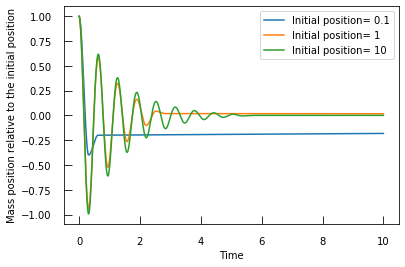

In [316]:
plt.plot(*simulate_spring_mass_funky_damper(0.1))
plt.plot(*simulate_spring_mass_funky_damper(1))
plt.plot(*simulate_spring_mass_funky_damper(10))
plt.legend(['Initial position= 0.1', 'Initial position= 1', 'Initial position= 10'])
plt.ylabel('Mass position relative to the initial position')
plt.xlabel('Time')
plt.show()

In [320]:
from numba import prange

def run_sims(end=1):
    for x0 in range(int(end/0.1)):
        if x0 == 0:
            continue
        simulate_spring_mass_funky_damper(x0*0.1)
        
%timeit run_sims()#had to do it for only one initial parameter

2.72 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [321]:
from numba import njit
@njit(nogil=True)#no need for a parallel=true here
def friction_fn(v, vt):
    if v > vt:
        return - v * 3
    else:
        return - vt * 3 * np.sign(v)

@njit(nogil=True)
def simulate_spring_mass_funky_damper(x0, T=10, dt=0.0001, vt=1.0):#no need for a parallel=true here since each calculation depends on the previous in the loop
    times = np.arange(0, T, dt)
    positions = np.zeros_like(times)
    
    v = 0
    a = 0
    x = x0
    positions[0] = x0/x0
    
    for ii in range(len(times)):
        if ii == 0:
            continue
        t = times[ii]
        a = friction_fn(v, vt) - 100*x
        v = v + a*dt
        x = x + v*dt
        positions[ii] = x/x0
    return times, positions

# compile
_ = simulate_spring_mass_funky_damper(0.1)

In [322]:
from numba import prange
@njit(nogil=True, parallel=True)# here we put parallel=true because we want to parralelized the solution according to different initial condition
def run_sims(end=10):
    for x0 in prange(int(end/0.1)):
        if x0 == 0:
            continue
        simulate_spring_mass_funky_damper(x0*0.1)
        
%timeit run_sims()#here it is for 10 initial parameters!So it is 1000 times faster

27.2 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Boostrapping data to compare empirical dictribution function: http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/lessons/lesson_07/intro_bootstrap.html

The dataset and part of the exercise is coming from caltech. Indeed anything after the step where I evaluate 95% confidence interval on the mean is not from them. Moreover the 95%  confidence interval calculation for the mean (as done by Caltech) is incorrect (or let's say not mathematically backed up) : you can not just take the 95 percent confidence interval from the boostrapped distribution directly. For confidence interval of a mean estimator, mathematical reasoning imposes you to center your data around the empirical mean (i.e. bootstrap is not here to give you a mean and a CI, but instead given a mean it gives you a CI : see Jeremi Orloff and Jonathan Bloom class from MIT for more ) 

Let's test if pesticides affect reproductive abilities of bees.

We have a dataset that contains measurements of alive sperms between two population of bees, one being in contact with pesticide whereas another is not.

Is there a statiscally significant difference in term of alive sperm between these two populations?

You don't know what is the actual parametrization of those different distributions, the only thing that you have is an empirical distribution. Thus, you are left with nonparametric statistics and the usage of summary statistics (actually Kolmogorv Smirnoff test would have been a good thing to try too): how different our estimations of means of those two distributions are, considering the confidence interval of those estimators.

For that, we need to estimate the mean of those two distributions and the confidence interval we have on those estimators, and one way to do it is to use boostrapping, which is a sampling method with replacement. You randomly draw N points from your data (there is replacement so some data points will be repeated in this sample), N being the size of your data set.

## How can it be parallelized?

Both the sampling and the summary statistics can be perfomed parallely.

In [4]:
import pandas as pd

df = pd.read_csv('bee_sperm.csv')
df.head()

,Specimen,Treatment,Environment,TreatmentNCSS,Sample ID,Colony,Cage,Sample,Sperm Volume per 500 ul,Quantity,ViabilityRaw (%),Quality,Age (d),Infertil,AliveSperm,Quantity Millions,Alive Sperm Millions,Dead Sperm Millions
0,227,Control,Cage,1,C2-1-1,2,1,1,2150000,2150000,96.72638146,96.726381,14,0,2079617,2.1500,2.079617,0.070383
1,228,Control,Cage,1,C2-1-2,2,1,2,2287500,2287500,96.34980798,96.349808,14,0,2204001,2.2875,2.204001,0.083499
2,229,Control,Cage,1,C2-1-3,2,1,3,87500,87500,98.75,98.750000,14,0,86406,0.0875,0.086406,0.001094
3,230,Control,Cage,1,C2-1-4,2,1,4,1875000,1875000,93.28742083,93.287421,14,0,1749139,1.8750,1.749139,0.125861
4,231,Control,Cage,1,C2-1-5,2,1,5,1587500,1587500,97.79250611,97.792506,14,0,1552456,1.5875,1.552456,0.035044


In [5]:
alive_ctrl = df.loc[df["Treatment"] == "Control", "Alive Sperm Millions"].values
alive_pest = df.loc[df["Treatment"] == "Pesticide", "Alive Sperm Millions"].values

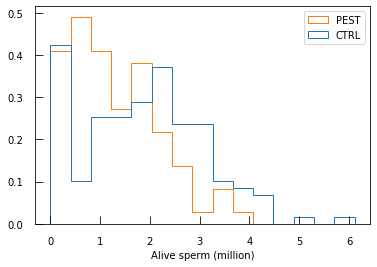

In [6]:
plt.hist([alive_ctrl,alive_pest],15,density=True,histtype='step',label=['CTRL','PEST'])
plt.legend(loc='best')
plt.xlabel('Alive sperm (million)')
plt.show()

That doesn't look too Gaussian...

In [7]:
@njit()
def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

In [8]:
@njit(nogil=True,parallel=True)
def draw_bs_reps_mean(data, size):
    """Draw boostrap replicates of the mean from 1D data set."""
    out_m = np.empty(size)
    
    for i in prange(size):
        out_m[i] = np.mean(draw_bs_sample(data))
        
    return out_m

In [9]:
bs_reps_mean_ctrl= draw_bs_reps_mean(alive_ctrl, size=10000)
bs_reps_mean_pest= draw_bs_reps_mean(alive_pest, size=10000)
x_bar_CTRL=np.mean(alive_ctrl)
x_bar_PEST=np.mean(alive_pest)

CTRL confidence interval [2.07118074 1.67397234] PEST confidence interval [1.4859222  1.10794272]


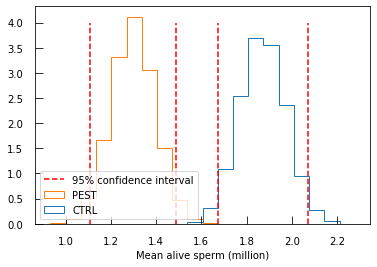

In [387]:
mean_ctrl_conf_int = x_bar_CTRL-np.percentile(bs_reps_mean_ctrl-x_bar_CTRL, [2.5, 97.5])
mean_pest_conf_int = x_bar_PEST-np.percentile(bs_reps_mean_pest-x_bar_PEST, [2.5, 97.5])

print('CTRL confidence interval',mean_ctrl_conf_int,'PEST confidence interval',mean_pest_conf_int)

plt.hist([bs_reps_mean_ctrl,bs_reps_mean_pest],20,density=True,histtype='step',label=['CTRL','PEST'])
plt.plot([mean_ctrl_conf_int[0],mean_ctrl_conf_int[0]],[0,4],'r--',label='95% confidence interval')
plt.plot([mean_ctrl_conf_int[1],mean_ctrl_conf_int[1]],[0,4],'r--')
plt.plot([mean_pest_conf_int[0],mean_pest_conf_int[0]],[0,4],'r--')
plt.plot([mean_pest_conf_int[1],mean_pest_conf_int[1]],[0,4],'r--')
plt.xlabel('Mean alive sperm (million)')
plt.legend(loc='best')
plt.show()

So within a 95% confidence interval those two means are different with the Pest mean being below the control mean.

Let's be even more quantitative by doing some hypothesis testing, still using bootstrapping. Let's compare the difference of means that we observe here between the two distributions, to a model where those two distributions are actually the same. We don't want to do all the hypothesis behind the t-test (homogeneity of variance, normality of data which we know is not true), so using bootstrapping we are going to simulate the distribution of mean differences if the two distributions were actually coming from the same distribution.

A way to do that is to transform the data as follow:

$x'=x-\bar{x}+\bar{z}$

$y'=y-\bar{y}+\bar{z}$

where $\bar{x}$ and $\bar{y}$ are the means of the different populations and $\bar{z}$ is the mean of the mixed population.

Your statistic is $t=\frac{\bar{x}-\bar{y}}{\sqrt{\frac{\sigma_{x}^{2}}{n}+\frac{\sigma_{y}^{2}}{m}}}$

where $\sigma_{x}$ is the standard deviation of population x and $\sigma_{y}$ is the standard deviation of population y and n and m their respective population sizes.

You then draw with replacement from your x' and y' (respectively with size n and m) and recover the distribution of test statistic:


$t'=\frac{\bar{x'}-\bar{y'}}{\sqrt{\frac{\sigma_{x'}^{2}}{n}+\frac{\sigma_{y'}^{2}}{m}}}$

In [12]:
all_data=df[ "Alive Sperm Millions"].values

x_bar_all=np.mean(all_data)
sigma_all=np.std(all_data)
sigma_CTRL=np.std(alive_ctrl)
sigma_PEST=np.std(alive_pest)

new_ctrl=np.array([v-x_bar_CTRL+x_bar_all for v in alive_ctrl])
new_pest=np.array([v-x_bar_PEST+x_bar_all for v in alive_pest])

In [14]:
@njit(parallel=True)
def draw_bs_reps_mean_std(data, size):
    """Draw boostrap replicates of the mean from 1D data set."""
    out_m = np.empty(size)
    out_s = np.empty(size)
    
    for i in prange(size):
        out_m[i] = np.mean(draw_bs_sample(data))
        out_s[i] = np.std(draw_bs_sample(data))
        
    return out_m,out_s

In [15]:
bs_reps_new_mean_ctrl,bs_reps_new_sd_ctrl= draw_bs_reps_mean_std(new_ctrl, size=100000)
bs_reps_new_mean_pest,bs_reps_new_sd_pest= draw_bs_reps_mean_std(new_pest, size=100000)

#### timing the bootstrap

In [400]:
%timeit draw_bs_reps_mean_std(new_ctrl, size=100000)

57.1 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [402]:
#without jit parallel
%timeit draw_bs_reps_mean_std(new_ctrl, size=100000)

433 ms ± 4.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [404]:
#without jit 
%timeit draw_bs_reps_mean_std(new_ctrl, size=100000)

3.02 s ± 76.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### timing the t statistic calculation

For the t statistic calculation I decided to use the vectorize decorator which allow me to define a universal function. Basically a universal function takes scalars and produce scalar. The decorator vectorize allow to pass it a vector instead of a scalar. It would be cool to write that as a jit and compare it to the vectorize.

Note taht in the case of universal function you need to stipulate the signature (type of your inputs and output)

Note also that you you could define a generalized universal function which this time accept arrays as input and give you an array as an output. In that case the decorator is guvectorize and the signature need to contain the relation between the size of the inputs and the size of the outputs. 

In [10]:
from numba import vectorize,float64,int32
@vectorize([float64(float64, float64,float64,float64,int32,int32)],target='parallel')
def t_stat_gen(x_bar1,x_bar2,sigma1,sigma2,n1,n2):
    return (x_bar1-x_bar2)/np.sqrt(sigma1*sigma1/n1+sigma2*sigma2/n2)

In [16]:
t_stat_data=t_stat_gen(x_bar_CTRL,x_bar_PEST,sigma_CTRL,sigma_PEST,len(alive_ctrl),len(alive_pest))
t_stat=t_stat_gen(bs_reps_new_mean_ctrl,bs_reps_new_mean_pest,bs_reps_new_sd_ctrl,bs_reps_new_sd_pest,len(alive_ctrl),len(alive_pest))

In [390]:
%timeit t_stat_gen(bs_reps_new_mean_ctrl,bs_reps_new_mean_pest,bs_reps_new_sd_ctrl,bs_reps_new_sd_pest,len(alive_ctrl),len(alive_pest))

106 µs ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [427]:
#without parallel
%timeit t_stat_gen(bs_reps_new_mean_ctrl,bs_reps_new_mean_pest,bs_reps_new_sd_ctrl,bs_reps_new_sd_pest,len(alive_ctrl),len(alive_pest))

490 µs ± 4.86 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Let's check how this piece of code would perfom if it was not written as a vectorized ufuncs (universal function)

In [22]:
def t_stat_gen_loop(x_bar1_l,x_bar2_l,sigma1_l,sigma2_l,n1,n2):
    return [(x_bar1-x_bar2)/np.sqrt(sigma1*sigma1/n1+sigma2*sigma2/n2)
                 for x_bar1,x_bar2,sigma1,sigma2 in zip(x_bar1_l,x_bar2_l,sigma1_l,sigma2_l)]
    

In [23]:
#not vectorized
%timeit t_stat_gen_loop(bs_reps_new_mean_ctrl,bs_reps_new_mean_pest,bs_reps_new_sd_ctrl,bs_reps_new_sd_pest,len(alive_ctrl),len(alive_pest))

253 ms ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
@njit(nogil=True,parallel=True)
def t_stat_gen_jit_loop(x_bar1_l,x_bar2_l,sigma1_l,sigma2_l,n1,n2):
    l=np.empty((len(sigma2_l),1))
    for i in prange(len(sigma2_l)):
        l[i,0]=(x_bar1_l[i]-x_bar2_l[i])/np.sqrt(sigma1_l[i]*sigma1_l[i]/n1+sigma2_l[i]*sigma2_l[i]/n2)
    return l

In [48]:

%timeit t_stat_gen_jit_loop(bs_reps_new_mean_ctrl,bs_reps_new_mean_pest,bs_reps_new_sd_ctrl,bs_reps_new_sd_pest,len(alive_ctrl),len(alive_pest))

The slowest run took 6.84 times longer than the fastest. This could mean that an intermediate result is being cached.
133 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
#no parallel

%timeit t_stat_gen_jit_loop(bs_reps_new_mean_ctrl,bs_reps_new_mean_pest,bs_reps_new_sd_ctrl,bs_reps_new_sd_pest,len(alive_ctrl),len(alive_pest))

489 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
# no njit loop
%timeit t_stat_gen_jit_loop(bs_reps_new_mean_ctrl,bs_reps_new_mean_pest,bs_reps_new_sd_ctrl,bs_reps_new_sd_pest,len(alive_ctrl),len(alive_pest))

364 ms ± 49.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Finally the answer

P-val= 2.0000000000020002e-05


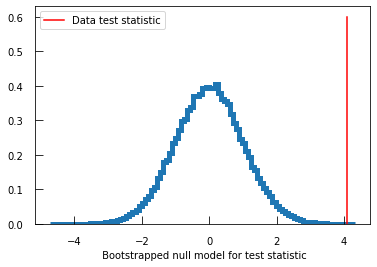

In [383]:
ordered_stat=sorted(t_stat)
for i,v in enumerate(ordered_stat):
    if v>t_stat_data:
        print('P-val=',1-(i+1)/len(ordered_stat))
        break

plt.hist(t_stat,100,histtype='step',density=True,linewidth=5)
plt.plot([t_stat_data,t_stat_data],[0,0.6],'r',label='Data test statistic')
plt.xlabel(' Bootstrapped null model for test statistic')
plt.legend(loc='best')
plt.show()

# Monte Carlo simulation for exact power statistics

Now, let's say that this sample collection is hard. We would like to get, from the pesticide population, the minimum number of samples that will still let us conclude with good confidence that there is (or is not) an effect from pesticide on bee sperm viability. For that we need power calculation. Since we are looking for small sample size, we can not really use the usual test assumptions (normal statistics).

I means we have to make some assumptions eventhough we know they are wrong... We can relax a bit the assumption of homogeneous variance by actually testing a few variances. But there is nothing (which is not too complex) to do about the assumption that the variances are chi square distributed...

Anyway let's perform Monte Carlo to simulate those probabilities:

So Power or the probability to reject the null hypothesis if the null hypothesis is false:

Power=$P(Z+\frac{\sqrt{n}*\Delta}{\sigma}<\frac{t_{\alpha,n-1}}{\sqrt{n-1}}\sqrt{\chi^{2}_{n-1}})$

Basically here the Monte Carlo simulation is equivalent to drawing many pairs of random variables. A pair is comprised of a normally distributed random variable and a chi squared distributed random variable. For those many pairs just count how many times the inequality above is true!

We will do that for many pesticide population sizes and many variances. We will settle for a population size that gives us a rather good power (at least 80%) and that is not too affected by the variance used.

In [432]:
#Monte Carlo bit of code
@njit#(nogil=True,parallel=True)
def MC(n_l,sigma_l,dd_l,delta=x_bar_CTRL-x_bar_PEST,N=100000):
    k=np.zeros((len(n_l),len(sigma_l)))
    indent=1./N
    for i in prange(len(n_l)):
        for j in prange(len(sigma_l)):
            for p in prange(N):
                aa=np.random.randn()+np.sqrt(n_l[i])*delta/sigma_l[j]
                bb=(dd_l[i]/np.sqrt(n_l[i]-1))*np.sqrt(np.random.chisquare(n_l[i]-1))
                if aa<bb:
                    k[i,j]+=indent
    return k



In [379]:
import scipy as sc
n_l=np.arange(2,100,1)# from 2 to 100 samples
dd_l=np.array([sc.stats.t.ppf(0.05,n_l[i]-1) for i in range(len(n_l))])#getting the t test stat values associated to those sample sizes
sigma_l=np.linspace(sigma_CTRL-sigma_CTRL/2,sigma_CTRL+sigma_CTRL/2,100)#spanning a variance around the control population variance

In [380]:
k=MC(n_l,sigma_l,dd_l,delta=x_bar_PEST-x_bar_CTRL,N=100000)#we settle for the delta we observed before and reconstruct
#the distribution P with 100000 draws.

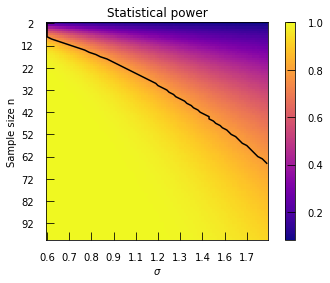

In [381]:
plt.imshow(k,interpolation='nearest',cmap='plasma')

keep_i=[]
keep_j=[]

for i in range(k.shape[0]):
    for j in range(k.shape[1]):
        if k[i,j]<0.8:
            keep_i.append(i)
            keep_j.append(j)
            break
            
plt.plot(keep_j,keep_i,'k')

plt.yticks(np.arange(0,len(n_l),10),[n_l[i] for i in range(0,len(n_l),10)])
plt.xticks(np.arange(0,len(sigma_l),10),[str(sigma_l[i])[:3]for i in range(0,len(sigma_l),10)])
plt.xlabel('$\sigma$')
plt.ylabel('Sample size n')
plt.colorbar()
plt.title('Statistical power')
plt.show()

The black line represents the limit in the parameter space where we have at least 80% power.

In [382]:
%timeit MC(n_l,sigma_l,dd_l,delta=x_bar_PEST-x_bar_CTRL,N=100000)

16.3 s ± 423 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [433]:
#no parallel
%timeit MC(n_l,sigma_l,dd_l,delta=x_bar_PEST-x_bar_CTRL,N=100000)

1min 28s ± 823 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


I am not risking doing it without jit given how much the parallel was important...